In [1]:
import requests
import pandas as pd
from datetime import datetime

# Base URL for the GDELT API
base_url = "https://api.gdeltproject.org/api/v2/doc/doc"

# Parameters for the query
params = {
    'query': 'climate change',
    'mode': 'artlist',  # Requesting a list of articles
    'maxrecords': 100,  # Limit to 100 articles
    'format': 'json',  # Response format
    'sort': 'datedesc',  # Sort by date descending
    'startdatetime': datetime(2022, 8, 17).strftime('%Y%m%d%H%M%S'),  # Start date in YYYYMMDDHHMMSS format
    'enddatetime': datetime(2023, 8, 24).strftime('%Y%m%d%H%M%S'),  # End date in YYYYMMDDHHMMSS format
}

# Make the request
response = requests.get(base_url, params=params)

# Check if the request was successful and content is not empty
if response.status_code == 200 and response.text:
    try:
        data = response.json()
        # Convert the articles into a DataFrame
        articles = pd.DataFrame(data['articles'])

        # Convert 'seendate' to a more readable format
        articles['seendate'] = pd.to_datetime(articles['seendate'], format='%Y%m%dT%H%M%SZ')

    except ValueError as e:
        print(f"Failed to parse JSON: {e}")
else:
    print(f"Failed to retrieve data or empty response: {response.status_code}")


In [2]:
articles.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry
0,https://www.tap.info.tn/en/Portal-Politics/165...,,,2023-08-25,,tap.info.tn,English,Tunisia
1,https://www.sohu.com/a/714666895_429139?edtsig...,,金砖国家领导人第十五次会晤约翰内斯堡宣言 _ 包括 _ 发展中国家 _ 支持,2023-08-25,,sohu.com,Chinese,China
2,https://www.begadistrictnews.com.au/story/8321...,,"Bega District Letters to the Editor , August 2...",2023-08-25,https://www.begadistrictnews.com.au/images/tra...,begadistrictnews.com.au,English,Australia
3,https://accesswdun.com/article/2023/8/1200883,,Environmental group suffers setback in legal f...,2023-08-25,https://mapi.associatedpress.com/v1/items/a83c...,accesswdun.com,English,United States
4,https://www.popularmechanics.com/science/a4489...,,How the Miracle House in Maui Survived Devas...,2023-08-25,https://hips.hearstapps.com/hmg-prod/images/an...,popularmechanics.com,English,United States


In [5]:
import google.generativeai as genai
import os


# read in the API key from file api_key 
with open('api_key', 'r') as f:
    api_key = f.readline().strip()

genai.configure(api_key=api_key)


The day the old, leather backpack appeared on Elias’s doorstep was the day his life changed. He was a boy of ten, living in a dusty, forgotten town, with nothing more exciting than the wind whistling through the cracks in his window. He found the backpack nestled in the overgrown weeds, its straps worn and faded, a single brass keyhole gleaming in the sunlight.

Inside, the backpack was empty. There was no note, no clue to its origin, only the faintest whisper of magic that tingled in the air around it. Elias, ever curious, unlocked the keyhole with a rusted key he found in his father’s workshop.  The moment he did, the backpack hummed, and a shimmering portal opened up inside.

At first, Elias was afraid, but curiosity won over. He reached inside, and his hand came out grasping a plump, juicy orange. It was the sweetest, most delicious orange he'd ever tasted. He devoured it, and then, with a thrill of excitement, reached in again. This time, he pulled out a small, silver flute. The m

Querying from 2024-04-10 08:32:14.736376 to 2024-07-09 08:32:14.736376...
Querying from 2024-07-10 08:32:14.736376 to 2024-10-07 08:32:14.736376...


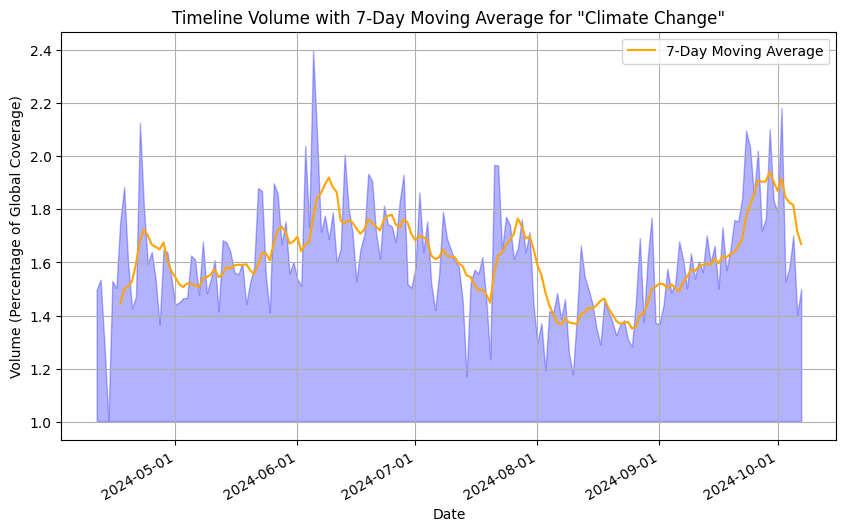

Querying from 2024-04-10 08:32:14.736376 to 2024-07-09 08:32:14.736376...
Querying from 2024-07-10 08:32:14.736376 to 2024-10-07 08:32:14.736376...


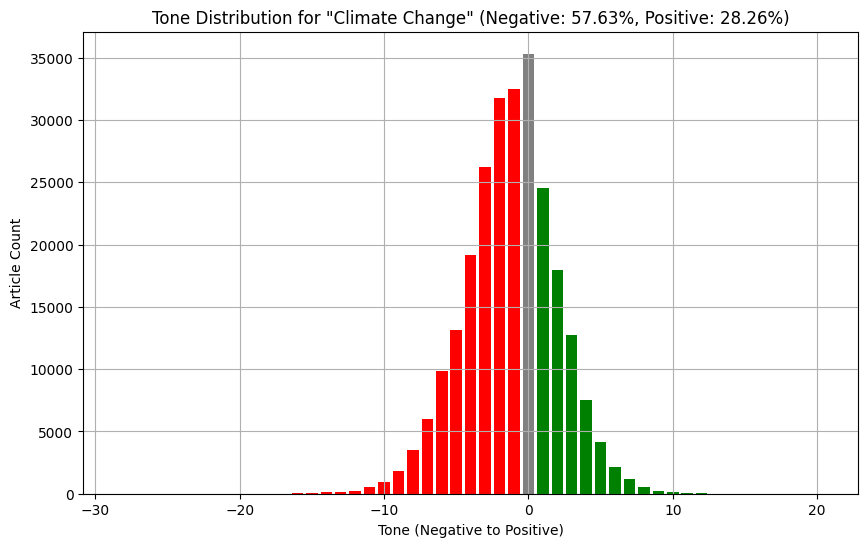

In [10]:
import streamlit as st
from gdeltdoc import GdeltDoc, Filters
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import google.generativeai as genai
import numpy as np
from matplotlib.dates import DateFormatter

def main():
    # Set up Streamlit app in wide mode and force light theme
    st.set_page_config(page_title="Global News Explorer", page_icon="📰", layout="wide", theme="light")
    apply_custom_styling()
    
    # Page Header
    st.markdown("<h1>📰 Global News Explorer 🌍</h1>", unsafe_allow_html=True)

    # Sidebar for user input
    with st.sidebar:
        keyword, lookback_period, limit_to_english = get_user_input()
        search_button = st.button("Search Articles")

    # Set up GDELT and Generative AI API
    gd = GdeltDoc()
    genai.configure(api_key=st.secrets["api_key"])
    model = genai.GenerativeModel("gemini-1.5-flash")

    # App Logic
    if search_button:
        if len(keyword) < 5:
            st.warning("🔍 Please enter at least 5 characters for the keyword.")
        else:
            with st.spinner("Retrieving news articles, please wait..."):
                articles_df, start_date, end_date = query_gdelt_data(gd, keyword, lookback_period, country_filter)
            
            if not articles_df.empty:
                display_summary(model, keyword, start_date, end_date, articles_df)
                display_wordcloud(articles_df)
                display_timeline(start_date, end_date)
                display_tone_chart()
                display_article_headlines(articles_df)
            else:
                st.warning("🤔 No articles found for the given search parameters.")

def apply_custom_styling():
    # Apply custom styling for the containers and overall look
    st.markdown("""
        <style>
        .container {
            padding: 15px;
            border: 2px solid #cccccc;
            border-radius: 10px;
            background-color: #f9f9f9;
            margin-bottom: 20px;
        }
        .stButton>button {
            background-color: #007BFF;
            color: white;
            padding: 0.5em 1em;
            border-radius: 5px;
            font-size: 1em;
        }
        .stButton>button:hover {
            background-color: #0056b3;
        }
        .reportview-container {
            background-color: #F0F2F6;
        }
        h1 {
            color: #333333;
            text-align: center;
            font-size: 2.5em;
            margin-top: 20px;
        }
        .summary {
            font-size: 1.2em;
            font-family: Arial, sans-serif;
            line-height: 1.5;
            color: #444444;
        }
        a.article-link {
            color: #007BFF;
            text-decoration: none;
        }
        a.article-link:hover {
            text-decoration: underline;
        }
        </style>
    """, unsafe_allow_html=True)

def get_user_input():
    st.header("🔍 Search Parameters")
    keyword = st.text_input("Enter Keyword", "Climate Change")
    lookback_options = ["1 week", "1 month", "3 months", "6 months", "1 year"]
    lookback_period = st.selectbox("Select Time Range", lookback_options, index=1)
    country_filter = st.radio("Select Coverage", ("Limit to US", "Entire World"), index=1)
    return keyword, lookback_period, country_filter

def query_gdelt_data(gd, keyword, lookback_period, country_filter):
    # Get date range based on lookback period
    end_date = datetime.now()
    start_date = get_start_date(lookback_period, end_date)
    
    # Format date for API
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    # Search filters
    filters = Filters(keyword=keyword, start_date=start_date_str, end_date=end_date_str)
    
    # Add country filter if needed
    if country_filter == "Limit to US":
        filters.source_country = 'us'
    
    # Get articles
    # Query GDELT API for articles
    articles = gd.article_search(filters)
    articles_df = pd.DataFrame(articles)
    
    
    return articles_df, start_date_str, end_date_str

def get_start_date(lookback_period, end_date):
    if lookback_period == "1 week":
        return end_date - pd.DateOffset(weeks=1)
    elif lookback_period == "1 month":
        return end_date - pd.DateOffset(months=1)
    elif lookback_period == "3 months":
        return end_date - pd.DateOffset(months=3)
    elif lookback_period == "6 months":
        return end_date - pd.DateOffset(months=6)
    elif lookback_period == "1 year":
        return end_date - pd.DateOffset(years=1)

def display_summary(model, keyword, start_date, end_date, articles_df):
    with st.container(border=True):
        st.markdown("<div class='container'><h3>🗑 Summary of Articles</h3></div>", unsafe_allow_html=True)
        articles_list = [f"Title: {row['title']}, URL: {row['url']}" for _, row in articles_df.iterrows()]
        articles_text = "\n".join(articles_list)
    
        prompt = (
            f"Summarize significant events related to '{keyword}' from {start_date} to {end_date}."
            f" Here are the top articles: {articles_text}"
        )
    
        try:
            response = model.generate_content(prompt)
            summary = response.text
        except Exception as e:
            st.error("An error occurred during summarization.")
            summary = "Summary not available due to an error."
        
        st.markdown(f"<div class='summary'>{summary}</div>", unsafe_allow_html=True)

def display_wordcloud(articles_df):
    with st.container(border=True):
        st.markdown("<div class='container'><h3>☁️ Word Cloud of Headlines</h3></div>", unsafe_allow_html=True)
        if 'title' in articles_df.columns:
            wordcloud = generate_wordcloud(" ".join(articles_df['title']))
            fig, ax = plt.subplots()
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis("off")
            st.pyplot(fig)

def generate_wordcloud(text):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords,
        colormap='viridis',
        collocations=False
    ).generate(text)
    
    return wordcloud

def display_timeline(start_date, end_date):
    with st.container(border=True):
        st.markdown("<div class='container'><h3>📊 Timeline Chart</h3></div>", unsafe_allow_html=True)
        # Generate fake timeline data (replace with actual API query)
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        timeline_data = pd.DataFrame({"date": dates, "value": np.random.randint(0, 100, size=len(dates))})
        plot_timeline(timeline_data)

def plot_timeline(timeline_df):
    timeline_df['date'] = pd.to_datetime(timeline_df['date'])
    timeline_df['value'] = pd.to_numeric(timeline_df['value'])
    timeline_df['moving_avg'] = timeline_df['value'].rolling(window=7).mean()

    plt.figure(figsize=(10, 6))
    plt.plot(timeline_df['date'], timeline_df['moving_avg'], label='7-Day Moving Average', color='orange')
    plt.fill_between(timeline_df['date'], timeline_df['value'].min(), timeline_df['value'], color='blue', alpha=0.3)
    plt.title('Timeline Volume with 7-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Volume (Percentage of Global Coverage)')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()
    st.pyplot(plt)

def display_tone_chart():
    with st.container(border=True):
        st.markdown("<div class='container'><h3>📉 Tone Chart</h3></div>", unsafe_allow_html=True)
        # Generate fake tone chart data (replace with actual API query)
        tone_data = pd.DataFrame({"bin": range(-10, 11), "count": np.random.randint(1, 100, size=21)})
        plot_tone_chart(tone_data)

def plot_tone_chart(tone_df):
    tone_df['bin'] = pd.to_numeric(tone_df['bin'])
    tone_df['count'] = pd.to_numeric(tone_df['count'])

    colors = ['red' if x < 0 else 'gray' if x == 0 else 'green' for x in tone_df['bin']]
    
    total_articles = tone_df['count'].sum()
    negative_articles = tone_df[tone_df['bin'] < 0]['count'].sum()
    positive_articles = tone_df[tone_df['bin'] > 0]['count'].sum()
    neutral_articles = tone_df[tone_df['bin'] == 0]['count'].sum()

    negative_percentage = (negative_articles / total_articles) * 100
    positive_percentage = (positive_articles / total_articles) * 100
    neutral_percentage = (neutral_articles / total_articles) * 100

    plt.figure(figsize=(10, 6))
    plt.bar(tone_df['bin'], tone_df['count'], color=colors)
    plt.title(f'Tone Distribution (Negative: {negative_percentage:.2f}%, Neutral: {neutral_percentage:.2f}%, Positive: {positive_percentage:.2f}%)')
    plt.xlabel('Tone (Negative to Positive)')
    plt.ylabel('Article Count')
    plt.grid(True)
    st.pyplot(plt)

def display_article_headlines(articles_df):
    with st.container(border=True):
        st.markdown("<div class='container'><h3>📰 Article Headlines</h3></div>", unsafe_allow_html=True)
        for index, row in articles_df.iterrows():
            st.markdown(f"[{row['title']}]({row['url']})", unsafe_allow_html=True)

if __name__ == "__main__":
    main()